## Merge two granules using pyresample

this note book takes two 5 minute modis granules and combines then into 1 image

In [1]:
%matplotlib inline

In [2]:
# %load temp.py


# ### Objective -- move center of image from Seattle to UBC 
# 
# We want to take an image centered on Seattle and move the image center to UBC

# In[1]:

from e582utils.data_read import download

import numpy as np
import h5py
import warnings
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import seaborn as sns
from e582lib.modis_chans import chan_dict
from e582lib.channels_reproject import subsample,find_corners
from e582lib.channels_reproject import resample_channels
from e582lib.map_slices import get_corners_centered, make_basemap_xy,make_xy
import pyproj
from affine import Affine
from rasterio.warp import calculate_default_transform
from rasterio.warp import reproject, Resampling
warnings.filterwarnings("ignore")
from pyresample import kd_tree, geometry
import pyresample

### convenience function to get col,row from lon,lat

In [3]:

def lon_lat_to_row_col(lon,lat,transform,projection):
    x,y=projection(lon,lat)
    col,row = ~transform*(x,y)
    return col,row

### get calibrated channels and lats,lons from level1b

In [4]:
def extract_channels(myd02file,myd03file,chan_list,chan_dict):
    reflectivity_list=[]
    for the_chan in chan_list:
        #
        # read channel channels
        #
        index = chan_dict[the_chan]['index']
        field_name = chan_dict[the_chan]['field_name']
        scale_name = chan_dict[the_chan]['scale']
        offset_name = chan_dict[the_chan]['offset']
        with h5py.File(myd02file, 'r') as h5_file:
            chan = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][field_name][
                index, :, :]
            scale = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
                field_name].attrs[scale_name][...]
            offset = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
                field_name].attrs[offset_name][...]
            chan_calibrated = (chan - offset[index]) * scale[index]
            chan_calibrated = chan_calibrated.astype(
                np.float32)  #convert from 64 bit to 32bit to save space
            reflectivity_list.append(chan_calibrated)
    with h5py.File(myd03file) as geo_file:
        lon_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Longitude'][...]
        lat_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Latitude'][...]
    return reflectivity_list,lon_data,lat_data

### Define the sampling area  between 13 deg and 51 deg latitude

map this region into a 500 row by 300 column array



In [5]:
projection_dict={'lon_0':-125,'lat_0':40}
projection_dict['datum']='WGS84'
projection_dict['proj'] = 'laea'
projection=pyproj.Proj(projection_dict)
ll_lon,ll_lat,ur_lon,ur_lat= -140,13,-70,51
ll_x,ll_y=projection(ll_lon,ll_lat)
ur_x,ur_y=projection(ur_lon,ur_lat)

area_extent = [ll_x, ll_y, ur_x, ur_y]
xsize=300
ysize=500

area_id='west'
area_name='westcoast'
proj_id='laea'

area_def_args = dict(
    area_id=area_id,
    area_name=area_name,
    proj_id=proj_id,
    area_dict=projection_dict,
    xsize=xsize,
    ysize=ysize,
    area_extent=area_extent)

area_def = geometry.AreaDefinition(area_id, area_name, 
                                   proj_id, projection_dict,
                                       xsize, ysize, area_extent)
print(area_def)

Area ID: west
Name: westcoast
Projection ID: laea
Projection: {'datum': 'WGS84', 'lat_0': '40', 'lon_0': '-125', 'proj': 'laea'}
Number of columns: 300
Number of rows: 500
Area extent: (-1664800.9444798825, -2844877.754174225, 3497875.6454524477, 2455419.385400784)


### this is the northern granule

In [6]:
myd02file="MYD021KM.A2016224.2100.006.2016225153002.h5"
download(myd02file)
myd03file="MYD03.A2016224.2100.006.2016225152335.h5"
download(myd03file)


MYD021KM.A2016224.2100.006.2016225153002.h5 already exists
and is 159039295 bytes
will not overwrite


MYD03.A2016224.2100.006.2016225152335.h5 already exists
and is 40795456 bytes
will not overwrite



### resample the northern granule onto the large grid

pyresample require missing values to be numbers, not ieee nan
set to -99999.

In [7]:
chan_list=['1','2','3','4']
reflectivity_list,lon_data,lat_data=\
         extract_channels(myd02file,myd03file,chan_list,chan_dict)
numchans=len(chan_list)
rows,cols=reflectivity_list[0].shape
chan_array=np.empty([rows,cols,numchans],dtype=np.float32)
for chan in range(numchans):
    chan_array[:,:,chan]=reflectivity_list[chan]

swath_def = geometry.SwathDefinition(lons=lon_data, lats=lat_data)

fill_value = -99999.

channels_north = kd_tree.resample_nearest(
    swath_def,
    chan_array,
    area_def,
    radius_of_influence=5000,
    nprocs=2,
    fill_value=fill_value)

nan_fill_value = np.array([np.nan], dtype=np.float32)[0]
channels_north[channels_north == fill_value] = nan_fill_value

### create the ndvi from resampled channels 1 and 2

In [8]:
affine_list = [area_def.pixel_size_x,0,area_def.area_extent[0],
               0,-area_def.pixel_size_y,area_def.area_extent[3]]
transform=Affine(*affine_list)
print(transform)
print('pixels are 17.2 km wide x 10.6 km tall')
proj4_string = area_def.proj4_string
proj_id = area_def.proj_id
height, width, num_chans = channels_north.shape
#
# add ndvi as a new layer so that channels
# grows to shape= rows x cols x 5
# 
ch1=channels_north[:,:,0]
ch2=channels_north[:,:,1]
ndvi_north=(ch2 - ch1)/(ch2 + ch1)

| 17208.92, 0.00,-1664800.94|
| 0.00,-10600.59, 2455419.39|
| 0.00, 0.00, 1.00|
pixels are 17.2 km wide x 10.6 km tall


### use imshow to plot the northern granule

In [9]:
cmap=sns.diverging_palette(261, 153,sep=6, s=95, l=76,as_cmap=True)
vmin= -0.9
vmax=  0.9
cmap.set_over('r')
cmap.set_under('k',alpha=0.8)
cmap.set_bad('w',alpha=0.1)
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)

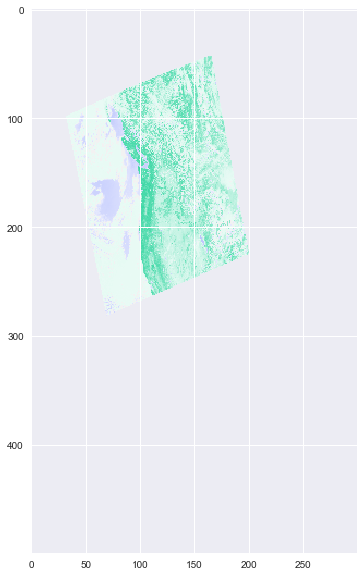

In [10]:
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(ndvi_north,origin='upper',cmap=cmap,norm=the_norm);

### now do the same thing for the southern granule

In [11]:
myd02file='MYD021KM.A2016224.2055.006.2016225153258.h5'
download(myd02file)
myd03file='MYD03.A2016224.2055.006.2016225152423.h5'
download(myd03file)
reflectivity_list,lon_data,lat_data=\
      extract_channels(myd02file,myd03file,chan_list,chan_dict)
numchans=len(chan_list)
rows,cols=reflectivity_list[0].shape
chan_array=np.empty([rows,cols,numchans],dtype=np.float32)
for chan in range(numchans):
    chan_array[:,:,chan]=reflectivity_list[chan]

swath_def = geometry.SwathDefinition(lons=lon_data, lats=lat_data)

fill_value = -99999.

channels_south = kd_tree.resample_nearest(
    swath_def,
    chan_array,
    area_def,
    radius_of_influence=5000,
    nprocs=2,
    fill_value=fill_value)

channels_south[channels_south == fill_value] = nan_fill_value

ch1=channels_south[:,:,0]
ch2=channels_south[:,:,1]
ndvi_south=(ch2 - ch1)/(ch2 + ch1)


MYD021KM.A2016224.2055.006.2016225153258.h5 already exists
and is 151287276 bytes
will not overwrite


MYD03.A2016224.2055.006.2016225152423.h5 already exists
and is 33671652 bytes
will not overwrite



### use imshow to show the southern granule

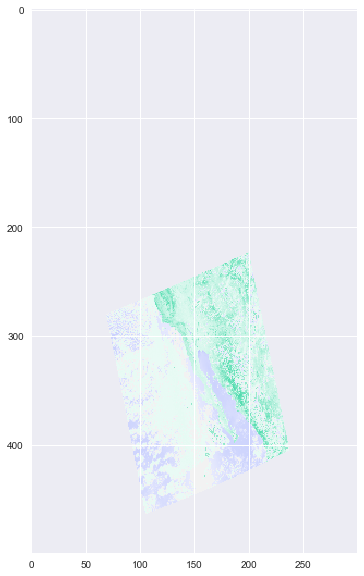

In [12]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(ndvi_south,origin='upper',cmap=cmap,norm=the_norm);

### find nan cells in the northern image.  Replace with data from the southern image

In [13]:
def stitch_chan(north,south):
    """
    replace pixels in north that are np.nan with pixels
    in south that contain valid floating point numbers
    """
    south_good_hit=np.logical_and(np.logical_not(np.isnan(south)),
                       np.isnan(north))
    north[south_good_hit]=south[south_good_hit]
    return north

ndvi = stitch_chan(ndvi_north,ndvi_south)
rows,cols=ndvi.shape
stitched_chans=np.empty([rows,cols,numchans+1],dtype=np.float32)
for chan in range(numchans):
    stitched = stitch_chan(channels_north[:,:,chan],channels_south[:,:,chan])
    stitched_chans[:,:,chan]=stitched[...]
stitched_chans[:,:,numchans]=ndvi[...]
chan_list.append('ndvi')

### use imshow to show merged image

note that the cells are not square, so swath looks distorted

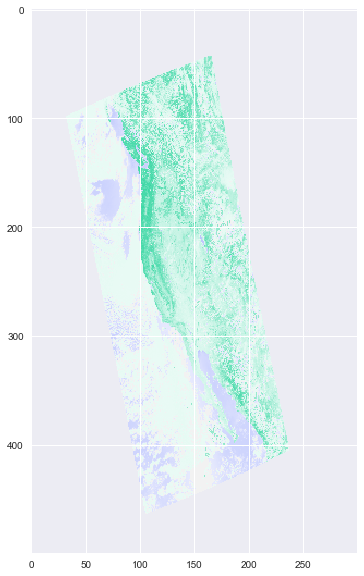

In [14]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(ndvi,origin='upper',cmap=cmap,norm=the_norm);

### now set up a basemap plot  

note that we have the affine transform for the pyresample reprojection,
so we are free to change the lat/lon corners of the plot to whatever
looks good and basemap will be able to figure out the project coordinates
and clip the image

In [15]:
height, width=ndvi.shape
ll_x,ll_y = transform*(0,height)
ur_x,ur_y = transform*(width,0)
lon_0,lat_0 = projection(0,0,inverse=True)
ll_lon,ll_lat = projection(ll_x,ll_y,inverse=True)
ur_lon,ur_lat = projection(ur_x,ur_y,inverse=True)
ll_lon,ll_lat= -130,17
ur_lon,ur_lat = -90,54
ll_dict=dict(llcrnrlat=ll_lat,llcrnrlon=ll_lon,urcrnrlat=ur_lat,
              urcrnrlon=ur_lon,lon_0=lon_0,lat_0=lat_0)


basemap_args = dict()
basemap_args['ellps'] = projection_dict['datum']
basemap_args.update(ll_dict)
basemap_args['projection'] = projection_dict['proj']
basemap_args['lat_0'] = projection_dict['lat_0']
basemap_args['lon_0'] = projection_dict['lon_0']

basemap_args['resolution']='c'
bmap=Basemap(**basemap_args)

### use basemap to get projection x,y values, and plot using ax.pcolormesh

note the easting and northing (x_0, y_0) that basemap adds to the coordinates

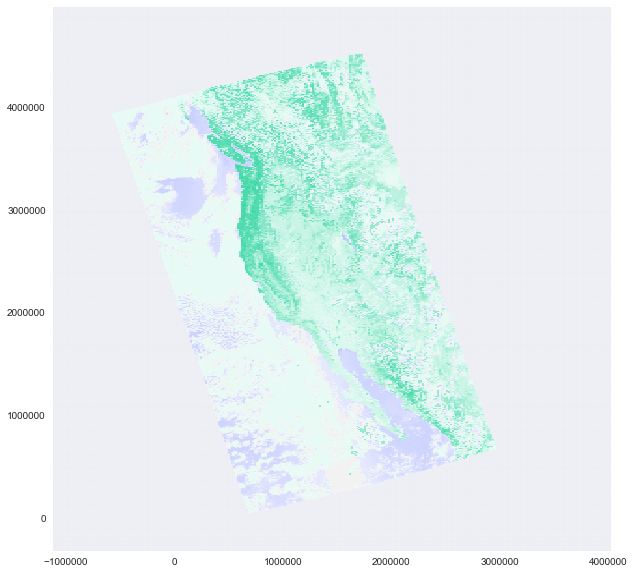

In [16]:
ndvi_masked=np.ma.masked_invalid(ndvi)
ur_row=0
ll_row=height
ll_col=0
ur_col=width
xvals,yvals = make_basemap_xy(ur_row,ll_row,ll_col,ur_col,bmap,transform)

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.pcolormesh(xvals,yvals,ndvi_masked,cmap=cmap,norm=the_norm);

### Finally, use basemap.pcolormesh to replot

note that basemap changes the aspect ratio

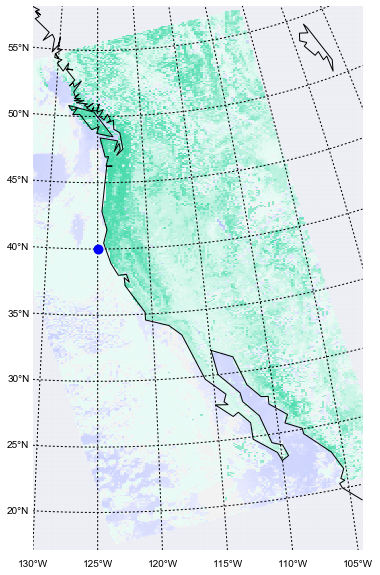

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
basemap_args['ax']=ax
bmap=Basemap(**basemap_args)
bmap.pcolormesh(xvals,yvals,ndvi_masked,cmap=cmap,norm=the_norm)
bmap.drawcoastlines()
lat_sep,lon_sep= 5, 5
parallels = np.arange(10, 60, lat_sep)
meridians = np.arange(-150,-90, lon_sep)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],
                        fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],
                       fontsize=10, latmax=90);
x0,y0=bmap(lon_0,lat_0)
bmap.plot(x0,y0,'bo',markersize=10);

In [18]:
### write h5 file
from e582lib.map_slices import write_h5
out_h5='stitched_out.h5'
write_h5(out_file=out_h5,affine_transform=transform,
         channels=stitched_chans,
         projection_dict=projection_dict,
         fill_value=nan_fill_value,
         chan_list=chan_list,
         comments='written by merge_modis notebook')

inside write_h5: channels shape=  (500, 300, 5)


In [21]:
### write tif file
from importlib import reload
out_tif = 'stretched_out.tif'
import e582lib.map_slices
reload(e582lib.map_slices)
from e582lib.map_slices import write_tif
write_tif(out_h5,out_tif)
import rasterio

key:  projection_dict {'datum': 'WGS84', 'lat_0': 40, 'lon_0': -125, 'proj': 'laea'}
key:  chan_list ['1', '2', '3', '4', 'ndvi']


In [27]:
src = rasterio.open(out_tif,'r')

In [28]:
src.profile

{'dtype': 'float32', 'tiled': False, 'crs': CRS({'no_defs': True, 'x_0': 0, 'datum': 'WGS84', 'lat_0': 40, 'units': 'm', 'lon_0': -125, 'proj': 'laea', 'y_0': 0}), 'height': 500, 'nodata': nan, 'transform': Affine(17208.9219664411, 0.0, -1664800.9444798825,
       0.0, -10600.594279150018, 2455419.385400784), 'interleave': 'pixel', 'count': 5, 'driver': 'GTiff', 'width': 300}

In [24]:
type(src.profile)

rasterio.profiles.Profile

In [25]:
out=dict(src.profile)

In [26]:
src.close()

In [29]:
list(out.keys())

['dtype',
 'nodata',
 'transform',
 'tiled',
 'crs',
 'count',
 'interleave',
 'height',
 'driver',
 'width']

In [30]:
src.crs

CRS({'no_defs': True, 'x_0': 0, 'datum': 'WGS84', 'lat_0': 40, 'units': 'm', 'lon_0': -125, 'proj': 'laea', 'y_0': 0})

In [31]:
dict(src.crs)

{'datum': 'WGS84',
 'lat_0': 40,
 'lon_0': -125,
 'no_defs': True,
 'proj': 'laea',
 'units': 'm',
 'x_0': 0,
 'y_0': 0}

In [32]:
src.transform

Affine(17208.9219664411, 0.0, -1664800.9444798825,
       0.0, -10600.594279150018, 2455419.385400784)